In [1]:
import numpy as np
import pandas as pd 
import cv2
from scipy.spatial import distance
import matplotlib.pyplot as plt


In [2]:
from xml.dom import minidom

# parse an xml file by name
mydoc = minidom.parse(r'haarcascade\haarcascade_frontalface_default.xml')

In [3]:
face_cascade_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

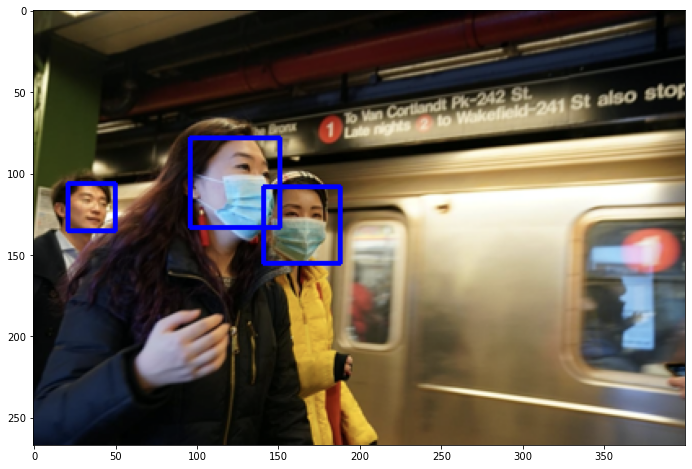

In [4]:
img = cv2.imread(r'sample_images\maksssksksss458.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_cascade_model.detectMultiScale(img)

img_output = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x, y, w, h) in faces:
    cv2.rectangle(img_output, (x, y), (x + w, y + h), (0, 0, 255), 2)

fig = plt.figure(figsize = (21,8))
plt.tight_layout()
plt.imshow(img_output)
    


In [5]:
###DISTANCE

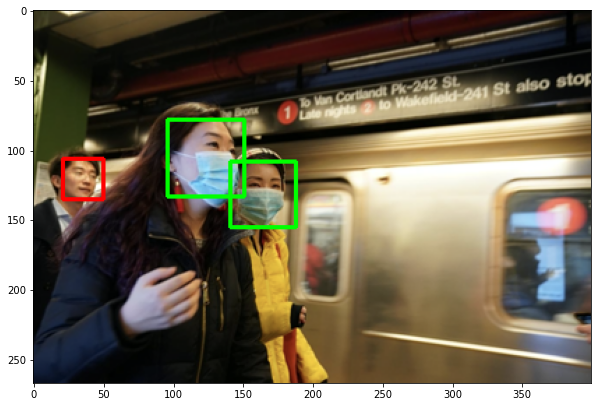

In [6]:
safe_distance = 80

if len(faces) >= 2 : # More than one person detected in the picture
    labels = [0 for i in range(len(faces))] # label for each person detected
    for i in range(len(faces) - 1):
        for j in range(i + 1, len(faces)):
            actual_distance = distance.euclidean(faces[i][:2], faces[j][:2])
            if actual_distance < safe_distance:
                labels[i] = 1 # within safe distance
                labels[j] = 1
    img_output = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        if labels[i] == 1:
            cv2.rectangle(img_output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
            cv2.rectangle(img_output, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.figure(figsize = (10, 10))
    plt.imshow(img_output)
    
else:
    print("Only one individual detected in the picture.")

In [7]:
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_dir = r'Train'
test_dir = r'Test'
validation_dir = r'Validation'


In [9]:
train_datagen = ImageDataGenerator(rescale = 1 / 255, horizontal_flip = True, zoom_range = 0.2, shear_range = 0.2)
train_generator = train_datagen.flow_from_directory(directory = train_dir, target_size = (128, 128), class_mode = 'categorical', batch_size = 32)

test_datagen = ImageDataGenerator(rescale = 1 / 255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)


val_datagen = ImageDataGenerator(rescale=1/255)
val_generator =val_datagen.flow_from_directory(directory=validation_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [10]:
# Creating the VGG19 CNN with the following input shpae (128, 128, 3) 
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))


In [11]:
for layer in vgg16.layers:
    layer.trainable = False # Avoid retraining
    
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(2, activation = 'softmax')) # 2 classes (with or without a mask), sigmoid for binary

In [12]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [13]:
cache = model.fit(train_generator, epochs=3, validation_data=val_generator)
                  

Epoch 1/3
313/313 [==============================] - 320s 1s/step - loss: 0.0765 - acc: 0.9733 - val_loss: 0.0280 - val_acc: 0.9925
Epoch 2/3
313/313 [==============================] - 308s 985ms/step - loss: 0.0269 - acc: 0.9915 - val_loss: 0.0241 - val_acc: 0.9912
Epoch 3/3
313/313 [==============================] - 315s 1s/step - loss: 0.0216 - acc: 0.9934 - val_loss: 0.0105 - val_acc: 0.9975


In [14]:
print("The model's respective loss and accuracy over the test set: ")
scores = model.evaluate(test_generator)

The model's respective loss and accuracy over the test set: 
31/31 [==============================] - 31s 1s/step - loss: 0.0190 - acc: 0.9950


#### Let's Predict 

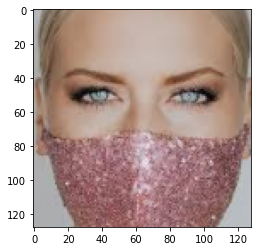

In [46]:
sample = cv2.imread(r'Test/WithMask/45.png')
sample = cv2.resize(sample, (128, 128))
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sample)

sample = np.reshape(sample, [1, 128, 128, 3]) # input shape for the model
sample = sample / 255.0

In [47]:
model.predict(sample)

array([[0.82186836, 0.17813171]], dtype=float32)